### Imports

In [17]:
import requests
import json
import pandas as pd
import ast
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import gensim
from gensim import corpora
from collections import Counter
import pandas as pd

import pandas as pd
from collections import Counter
import ast

# Label TaxoEntities
Now that entities have been extracted with TaxoNERD, we label them

In [18]:
# Function to flatten a list of lists (after converting from string representation) --> Functioin thought for handling the TaxRef multi-entity returns
def flatten_list_of_lists(row):
    # Convert the string representation to actual list
    lists = ast.literal_eval(row) #string_to_list(row)
    # Flatten the list of lists
    flattened = [(taxref, name) for sublist in lists for (taxref, name, _) in sublist]
    return flattened


def count_unique_entities_per_row_and_sort(entities_column):
    """
    Receives a pandas Series where each row contains a list or a string representation of a list of entities.
    Returns a pandas Series where each row contains an OrderedDict with the count of unique entities or tuples,
    sorted by their counts in descending order. It handles case insensitivity for strings and maintains the integrity of tuples.
    """
    def count_entities(row_entities):
        try:
            if isinstance(row_entities, str):
                # Safely convert string representation to actual list
                row_entities = ast.literal_eval(row_entities)

            row_entities_list = []
            for entity in row_entities:
                if isinstance(entity, tuple):
                    # Handle tuples by keeping them intact
                    row_entities_list.append(entity)
                elif isinstance(entity, str):
                    # Convert strings to lowercase for case insensitivity
                    row_entities_list.append(entity.lower())
                else:
                    # Ignore non-string, non-tuple entities
                    continue

            # Count entities/tuples and sort them
            entity_counter = Counter(row_entities_list)
            sorted_entities = dict(sorted(entity_counter.items(), key=lambda x: x[1], reverse=True))

            return sorted_entities
        except Exception as e:
            print(f"Error processing row: {e}")
            return {}

    # Apply the count_entities function to each row in the entities_column
    return entities_column.apply(count_entities)

## Sample of 20 papers (Dataset_2)

In [19]:
file_path = 'C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/entities_comparison.csv'
papers_df = pd.read_csv(file_path)
papers_df

,BABEL_entities,TaxoEntitiesBB,TaxoEntitiesBB2,TaxoEntitiesMD2,TaxoEntitiesMD2_GBIF,TaxoEntitiesMD2_x,TaxoEntitiesMD2_y,TaxoEntitiesMD_x,TaxoEntitiesMD_y,TaxoRefEntitiesBB2_x,TaxoRefEntitiesBB2_y,fileMain_s
0,"['France (LOC)', 'Creative Commons Attribution...","['clove agroforests', 'clove agroforests', 'cl...","['Stéphanie M. Carrière3', 'Verohanitra Rafidi...","['M. Carrière, Eric A. Penot', 'Verohanitra Ra...","[[('GBIF:3183002', 'clove', 0.7634411454200745...","['M. Carrière, Eric A. Penot', 'Verohanitra Ra...","[[('TAXREF:630768', 'Syzygium aromaticum', 1.0...","['Verohanitra Rafidison,', 'Vanesse Labeyrie',...","['Verohanitra Rafidison,', 'Vanesse Labeyrie',...","[[('TAXREF:447477', 'Coffee tree', 0.891860187...",NaN,https://hal.inrae.fr/hal-03461601/document
1,"['France (LOC)', 'Cloggs Cave (LOC)', 'SE (LOC...","['disc- faced owls', 'Tyto novaehollandae', 'M...","['disc- faced owls', 'Tyto novaehollandae', 'M...","['GunaiKurnai Land and Waters', 'Cloggs Cave',...","[[('GBIF:9065640', 'Tyto novaehollandiae novae...","['GunaiKurnai Land and Waters', 'Cloggs Cave',...","[[('TAXREF:712345', 'Proto novaehollandiae', 0...","['Larchive ouverte pluridisciplinaire HAL', 'C...","['Larchive ouverte pluridisciplinaire HAL', 'C...","[[('TAXREF:712345', 'Proto novaehollandiae', 0...",NaN,https://hal.science/hal-03829927/document
2,"['People and Nature (MISC)', 'Biraben (PER)', ...","['popu lation', 'lon ger', 'Muthukrishna', 'no...","['Muthukrishna', 'norfolk']","['anti‐human’', 'Anderies', 'Malthus’ theory',...",[],"['anti‐human’', 'Anderies', 'Malthus’ theory',...",[],"['EXISTINGTHEORIESANDMODELS', 'medieval agri',...","['EXISTINGTHEORIESANDMODELS', 'medieval agri',...","[[('TAXREF:592318', 'Coralliophila norfolk', 0...",NaN,https://hal.science/hal-02350603/document
3,"['France (LOC)', 'Mélanie Congretel (PER)', 'F...","['guarana', 'guarana', 'Paullinia cupana', 'Ku...","['guarana', 'waraná', 'guarana', 'Paullinia cu...","['Sateré', 'Paullinia cupana (Kunth var. sorbi...","[[('GBIF:5786457', 'Sateré Marmoset', 0.771187...","['Sateré', 'Paullinia cupana (Kunth var. sorbi...","[[('TAXREF:841466', 'Paullinia cupana var. sor...","['Mlanie', 'Larchive ouverte pluridisciplinair...","['Mlanie', 'Larchive ouverte pluridisciplinair...","[[('TAXREF:734243', 'Guarea guara', 0.78600811...",NaN,https://shs.hal.science/halshs-02937670/document
4,"['People and Nature (MISC)', 'Werner Ulrich (P...","['Serrano-', 'Carnero', 'Rembiakowska', 'Stahl...","['Léa Beaumelle', 'Beaumelle', 'Rembiałkowska'...","['Péter Batáry2 | Julia', 'León', 'B. wA', 'Pé...","[[('GBIF:4494312', 'Spilomena beata Blüthgen',...","['Péter Batáry2 | Julia', 'León', 'B. wA', 'Pé...","[[('TAXREF:210056', 'Cephalochilus Blüthgen, 1...","['Andrea erevkov Enrique', 'Blthgen', 'Lefchec...","['Andrea erevkov Enrique', 'Blthgen', 'Lefchec...",[],NaN,https://cnam.hal.science/hal-04080723/document
5,"['France (LOC)', 'Creative Commons Attribution...","['Dimitra Mylona', 'Dimitra Mylona9|', 'Katia ...","['Dimitra Mylona', 'Katia Frangoudes', 'Dimitr...","['Katia Frangoudes, et', 'PERICLES project,1',...","[[('GBIF:7207559', 'Agrias pericles pericles',...","['Katia Frangoudes, et', 'PERICLES project,1',...","[[('TAXREF:750521', 'Agrias pericles', 0.73106...","['Katia Frangoudes, et al.', 'Larchive ouverte...","['Katia Frangoudes, et al.', 'Larchive ouverte...","[[('TAXREF:730671', 'Salmonia', 0.851587712764...",NaN,https://hal.inrae.fr/hal-04085146/document
6,"['France (LOC)', 'Bengaluru (LOC)', 'India (LO...","['Aedes', 'dengue', 'chikungunya', 'Aedes-', '...","['Aedes', 'dengue', 'chikungunya', 'yellow', '...","['Genève', 'Université', 'Aedes genus', 'Arctu...","[[('GBIF:4755059', 'Aedenus', 0.77683901786804...","['Genève', 'Université', 'Aedes genus', 'Arctu...","[[('TAXREF:188832', 'Aedes', 0.773127555847168...","['Larchive ouverte pluridisciplinaire HAL', 'A...","['Larchive ouverte pluridisciplinaire HAL', 'A...","[[('TAXREF:188832', 'Aedes', 1.0), ('TAXREF:82...",NaN,https://hal.sc

In [20]:
file_path = 'C:/Users/maria/OneDrive/Documentos/Thesis/dataset_3/entities-20-MD_NCBI_v3.csv'
nbci_entities = pd.read_csv(file_path)
nbci_entities

,fileMain_s,TaxoEntitiesMD2_NCBI
0,https://hal.inrae.fr/hal-03461601/document,"[[('NCBI:219868', 'clove', 0.7502766251564026)..."
1,https://hal.science/hal-03829927/document,"[[('NCBI:507994', 'Tyto novaehollandiae', 0.91..."
2,https://hal.science/hal-02350603/document,[]
3,https://shs.hal.science/halshs-02937670/document,"[[('NCBI:392746', 'Paullinia cupana var. sorbi..."
4,https://cnam.hal.science/hal-04080723/document,"[[('NCBI:378092', 'Molnaria', 0.71836060285568..."
5,https://hal.inrae.fr/hal-04085146/document,"[[('NCBI:172714', 'kelp bass', 0.8092926144599..."
6,https://hal.science/hal-03953883/document,"[[('NCBI:1250594', 'Osmia universitatis', 0.70..."
7,https://hal.science/hal-03482462/document,"[[('NCBI:1101089', 'Cedestis', 0.7583553791046..."
8,https://hal.inrae.fr/hal-04285321/document,"[[('NCBI:9170', 'starlings', 1.0)], [('NCBI:91..."
9,https://hal.science/hal-03511302/document,"[[('NCBI:301659', 'Carmenta', 0.88153719902038..."


In [21]:
papers_df = papers_df.merge(nbci_entities, on='fileMain_s', how='left')
papers_df

,BABEL_entities,TaxoEntitiesBB,TaxoEntitiesBB2,TaxoEntitiesMD2,TaxoEntitiesMD2_GBIF,TaxoEntitiesMD2_x,TaxoEntitiesMD2_y,TaxoEntitiesMD_x,TaxoEntitiesMD_y,TaxoRefEntitiesBB2_x,TaxoRefEntitiesBB2_y,fileMain_s,TaxoEntitiesMD2_NCBI
0,"['France (LOC)', 'Creative Commons Attribution...","['clove agroforests', 'clove agroforests', 'cl...","['Stéphanie M. Carrière3', 'Verohanitra Rafidi...","['M. Carrière, Eric A. Penot', 'Verohanitra Ra...","[[('GBIF:3183002', 'clove', 0.7634411454200745...","['M. Carrière, Eric A. Penot', 'Verohanitra Ra...","[[('TAXREF:630768', 'Syzygium aromaticum', 1.0...","['Verohanitra Rafidison,', 'Vanesse Labeyrie',...","['Verohanitra Rafidison,', 'Vanesse Labeyrie',...","[[('TAXREF:447477', 'Coffee tree', 0.891860187...",NaN,https://hal.inrae.fr/hal-03461601/document,"[[('NCBI:219868', 'clove', 0.7502766251564026)..."
1,"['France (LOC)', 'Cloggs Cave (LOC)', 'SE (LOC...","['disc- faced owls', 'Tyto novaehollandae', 'M...","['disc- faced owls', 'Tyto novaehollandae', 'M...","['GunaiKurnai Land and Waters', 'Cloggs Cave',...","[[('GBIF:9065640', 'Tyto novaehollandiae novae...","['GunaiKurnai Land and Waters', 'Cloggs Cave',...","[[('TAXREF:712345', 'Proto novaehollandiae', 0...","['Larchive ouverte pluridisciplinaire HAL', 'C...","['Larchive ouverte pluridisciplinaire HAL', 'C...","[[('TAXREF:712345', 'Proto novaehollandiae', 0...",NaN,https://hal.science/hal-03829927/document,"[[('NCBI:507994', 'Tyto novaehollandiae', 0.91..."
2,"['People and Nature (MISC)', 'Biraben (PER)', ...","['popu lation', 'lon ger', 'Muthukrishna', 'no...","['Muthukrishna', 'norfolk']","['anti‐human’', 'Anderies', 'Malthus’ theory',...",[],"['anti‐human’', 'Anderies', 'Malthus’ theory',...",[],"['EXISTINGTHEORIESANDMODELS', 'medieval agri',...","['EXISTINGTHEORIESANDMODELS', 'medieval agri',...","[[('TAXREF:592318', 'Coralliophila norfolk', 0...",NaN,https://hal.science/hal-02350603/document,[]
3,"['France (LOC)', 'Mélanie Congretel (PER)', 'F...","['guarana', 'guarana', 'Paullinia cupana', 'Ku...","['guarana', 'waraná', 'guarana', 'Paullinia cu...","['Sateré', 'Paullinia cupana (Kunth var. sorbi...","[[('GBIF:5786457', 'Sateré Marmoset', 0.771187...","['Sateré', 'Paullinia cupana (Kunth var. sorbi...","[[('TAXREF:841466', 'Paullinia cupana var. sor...","['Mlanie', 'Larchive ouverte pluridisciplinair...","['Mlanie', 'Larchive ouverte pluridisciplinair...","[[('TAXREF:734243', 'Guarea guara', 0.78600811...",NaN,https://shs.hal.science/halshs-02937670/document,"[[('NCBI:392746', 'Paullinia cupana var. sorbi..."
4,"['People and Nature (MISC)', 'Werner Ulrich (P...","['Serrano-', 'Carnero', 'Rembiakowska', 'Stahl...","['Léa Beaumelle', 'Beaumelle', 'Rembiałkowska'...","['Péter Batáry2 | Julia', 'León', 'B. wA', 'Pé...","[[('GBIF:4494312', 'Spilomena beata Blüthgen',...","['Péter Batáry2 | Julia', 'León', 'B. wA', 'Pé...","[[('TAXREF:210056', 'Cephalochilus Blüthgen, 1...","['Andrea erevkov Enrique', 'Blthgen', 'Lefchec...","['Andrea erevkov Enrique', 'Blthgen', 'Lefchec...",[],NaN,https://cnam.hal.science/hal-04080723/document,"[[('NCBI:378092', 'Molnaria', 0.71836060285568..."
5,"['France (LOC)', 'Creative Commons Attribution...","['Dimitra Mylona', 'Dimitra Mylona9|', 'Katia ...","['Dimitra Mylona', 'Katia Frangoudes', 'Dimitr...","['Katia Frangoudes, et', 'PERICLES project,1',...","[[('GBIF:7207559', 'Agrias pericles pericles',...","['Katia Frangoudes, et', 'PERICLES project,1',...","[[('TAXREF:750521', 'Agrias pericles', 0.73106...","['Katia Frangoudes, et al.', 'Larchive ouverte...","['Katia Frangoudes, et al.', 'Larchive ouverte...","[[('TAXREF:730671', 'Salmonia', 0.851587712764...",NaN,https://hal.inrae.fr/hal-04085146/document,"[[('NCBI:172714', 'kelp bass', 0.8092926144599..."
6,"['France (LOC)', 'Bengaluru (LOC)', 'India (LO...","['Aedes', 'dengue', 'chikungunya', 'Aedes-', '...","['Aedes', 'dengue', 'chikungunya', 'yellow', '...","['Genève', 'Université', 'Aedes genus', 'Arctu...","[[('GBIF:4755059', 'Aedenus', 0.7768390178680

Remove repeated columns

In [27]:
papers_df.columns.to_list()

['BABEL_entities',
 'TaxoEntitiesBB',
 'TaxoEntitiesBB2',
 'TaxoEntitiesMD2',
 'TaxoEntitiesMD2_GBIF',
 'TaxoEntitiesMD2_x',
 'TaxoEntitiesMD2_y',
 'TaxoEntitiesMD_x',
 'TaxoEntitiesMD_y',
 'TaxoRefEntitiesBB2_x',
 'TaxoRefEntitiesBB2_y',
 'fileMain_s',
 'TaxoEntitiesMD2_NCBI']

In [29]:
def validate_and_clean_columns(df):
    columns = df.columns
    to_drop = []
    differences = {}

    for col in columns:
        if col.endswith('_x'):
            base_col = col[:-2]
            col_y = base_col + '_y'
            if col_y in columns:
                if df[col].equals(df[col_y]):
                    df.rename(columns={col: base_col}, inplace=True)
                    to_drop.append(col_y)
                else:
                    differences[base_col] = df[df[col] != df[col_y]]
    
    df.drop(columns=to_drop, inplace=True)
    return df, differences

# Example usage
papers_df, differences = validate_and_clean_columns(papers_df)

# If you want to display the rows where there are differences
for base_col, diff_df in differences.items():
    print(f"Differences in {base_col}:")
    print(diff_df)

Differences in TaxoEntitiesMD2:
                                       BABEL_entities  \
0   ['France (LOC)', 'Creative Commons Attribution...   
1   ['France (LOC)', 'Cloggs Cave (LOC)', 'SE (LOC...   
2   ['People and Nature (MISC)', 'Biraben (PER)', ...   
3   ['France (LOC)', 'Mélanie Congretel (PER)', 'F...   
4   ['People and Nature (MISC)', 'Werner Ulrich (P...   
5   ['France (LOC)', 'Creative Commons Attribution...   
6   ['France (LOC)', 'Bengaluru (LOC)', 'India (LO...   
7   ['People and Nature (MISC)', 'Emilia Pramova (...   
8   ['People and Nature (MISC)', 'Thomas Evans (PE...   
9   ['France (LOC)', 'Creative Commons Attribution...   
10  ['France (LOC)', 'Creative Commons Attribution...   
11  ['People and Nature (MISC)', 'Madagascar (LOC)...   
12  ['People and Nature (MISC)', 'Transfrontier Co...   
13  ['France (LOC)', 'Lauric Thiault (PER)', 'Stef...   
14  ['People and Nature (MISC)', 'Mathilde Jackson...   
15  ['France (LOC)', 'Laos (LOC)', 'Gilles Maurer ...   

                                       BABEL_entities  \
0   ['France (LOC)', 'Creative Commons Attribution...   
1   ['France (LOC)', 'Cloggs Cave (LOC)', 'SE (LOC...   
2   ['People and Nature (MISC)', 'Biraben (PER)', ...   
3   ['France (LOC)', 'Mélanie Congretel (PER)', 'F...   
4   ['People and Nature (MISC)', 'Werner Ulrich (P...   
5   ['France (LOC)', 'Creative Commons Attribution...   
6   ['France (LOC)', 'Bengaluru (LOC)', 'India (LO...   
7   ['People and Nature (MISC)', 'Emilia Pramova (...   
8   ['People and Nature (MISC)', 'Thomas Evans (PE...   
9   ['France (LOC)', 'Creative Commons Attribution...   
10  ['France (LOC)', 'Creative Commons Attribution...   
11  ['People and Nature (MISC)', 'Madagascar (LOC)...   
12  ['People and Nature (MISC)', 'Transfrontier Co...   
13  ['France (LOC)', 'Lauric Thiault (PER)', 'Stef...   
14  ['People and Nature (MISC)', 'Mathilde Jackson...   
15  ['France (LOC)', 'Laos (LOC)', 'Gilles Maurer ...   
16  ['France (LOC)', 'Christoph

In [30]:
papers_df

,BABEL_entities,TaxoEntitiesBB,TaxoEntitiesBB2,TaxoEntitiesMD2,TaxoEntitiesMD2_GBIF,TaxoEntitiesMD2_x,TaxoEntitiesMD2_y,TaxoEntitiesMD,TaxoRefEntitiesBB2_x,TaxoRefEntitiesBB2_y,fileMain_s,TaxoEntitiesMD2_NCBI
0,"['France (LOC)', 'Creative Commons Attribution...","['clove agroforests', 'clove agroforests', 'cl...","['Stéphanie M. Carrière3', 'Verohanitra Rafidi...","['M. Carrière, Eric A. Penot', 'Verohanitra Ra...","[(GBIF:3183002, clove), (GBIF:3183002, Syzygiu...","['M. Carrière, Eric A. Penot', 'Verohanitra Ra...","[(TAXREF:630768, Syzygium aromaticum), (TAXREF...","['Verohanitra Rafidison,', 'Vanesse Labeyrie',...","[(TAXREF:447477, Coffee tree), (TAXREF:630768,...",NaN,https://hal.inrae.fr/hal-03461601/document,"[(NCBI:219868, clove), (NCBI:219868, clove), (..."
1,"['France (LOC)', 'Cloggs Cave (LOC)', 'SE (LOC...","['disc- faced owls', 'Tyto novaehollandae', 'M...","['disc- faced owls', 'Tyto novaehollandae', 'M...","['GunaiKurnai Land and Waters', 'Cloggs Cave',...","[(GBIF:9065640, Tyto novaehollandiae novaeholl...","['GunaiKurnai Land and Waters', 'Cloggs Cave',...","[(TAXREF:712345, Proto novaehollandiae), (TAXR...","['Larchive ouverte pluridisciplinaire HAL', 'C...","[(TAXREF:712345, Proto novaehollandiae), (TAXR...",NaN,https://hal.science/hal-03829927/document,"[(NCBI:507994, Tyto novaehollandiae), (NCBI:21..."
2,"['People and Nature (MISC)', 'Biraben (PER)', ...","['popu lation', 'lon ger', 'Muthukrishna', 'no...","['Muthukrishna', 'norfolk']","['anti‐human’', 'Anderies', 'Malthus’ theory',...",[],"['anti‐human’', 'Anderies', 'Malthus’ theory',...",[],"['EXISTINGTHEORIESANDMODELS', 'medieval agri',...","[(TAXREF:592318, Coralliophila norfolk)]",NaN,https://hal.science/hal-02350603/document,[]
3,"['France (LOC)', 'Mélanie Congretel (PER)', 'F...","['guarana', 'guarana', 'Paullinia cupana', 'Ku...","['guarana', 'waraná', 'guarana', 'Paullinia cu...","['Sateré', 'Paullinia cupana (Kunth var. sorbi...","[(GBIF:5786457, Sateré Marmoset), (GBIF:378489...","['Sateré', 'Paullinia cupana (Kunth var. sorbi...","[(TAXREF:841466, Paullinia cupana var. sorbili...","['Mlanie', 'Larchive ouverte pluridisciplinair...","[(TAXREF:734243, Guarea guara), (TAXREF:734243...",NaN,https://shs.hal.science/halshs-02937670/document,"[(NCBI:392746, Paullinia cupana var. sorbilis)..."
4,"['People and Nature (MISC)', 'Werner Ulrich (P...","['Serrano-', 'Carnero', 'Rembiakowska', 'Stahl...","['Léa Beaumelle', 'Beaumelle', 'Rembiałkowska'...","['Péter Batáry2 | Julia', 'León', 'B. wA', 'Pé...","[(GBIF:4494312, Spilomena beata Blüthgen), (GB...","['Péter Batáry2 | Julia', 'León', 'B. wA', 'Pé...","[(TAXREF:210056, Cephalochilus Blüthgen, 1939)...","['Andrea erevkov Enrique', 'Blthgen', 'Lefchec...",[],NaN,https://cnam.hal.science/hal-04080723/document,"[(NCBI:378092, Molnaria), (NCBI:122956, Setia)..."
5,"['France (LOC)', 'Creative Commons Attribution...","['Dimitra Mylona', 'Dimitra Mylona9|', 'Katia ...","['Dimitra Mylona', 'Katia Frangoudes', 'Dimitr...","['Katia Frangoudes, et', 'PERICLES project,1',...","[(GBIF:7207559, Agrias pericles pericles), (GB...","['Katia Frangoudes, et', 'PERICLES project,1',...","[(TAXREF:750521, Agrias pericles), (TAXREF:733...","['Katia Frangoudes, et al.', 'Larchive ouverte...","[(TAXREF:730671, Salmonia), (TAXREF:186049, ga...",NaN,https://hal.inrae.fr/hal-04085146/document,"[(NCBI:172714, kelp bass), (NCBI:172714, kelp ..."
6,"['France (LOC)', 'Bengaluru (LOC)', 'India (LO...","['Aedes', 'dengue', 'chikungunya', 'Aedes-', '...","['Aedes', 'dengue', 'chikungunya', 'yellow', '...","['Genève', 'Université', 'Aedes genus', 'Arctu...","[(GBIF:4755059, Aedenus), (GBIF:2199187, Arctu...","['Genève', 'Université', 'Aedes genus', 'Arctu...","[(TAXREF:188832, Aedes), (TAXREF:820224, Aedes...","['Larchive ouverte pluridisciplinaire HAL', 'A...","[(TAXREF:188832, Aedes), (TAXREF:820224, Aedes...",NaN,https://hal.science/hal-03953883/document,"[(NCBI:1250594, Osmia universitatis), (NCBI:14..."
7,"['People and Nature (MISC

In [33]:
differences

{'TaxoEntitiesMD2':                                        BABEL_entities  \
 0   ['France (LOC)', 'Creative Commons Attribution...   
 1   ['France (LOC)', 'Cloggs Cave (LOC)', 'SE (LOC...   
 2   ['People and Nature (MISC)', 'Biraben (PER)', ...   
 3   ['France (LOC)', 'Mélanie Congretel (PER)', 'F...   
 4   ['People and Nature (MISC)', 'Werner Ulrich (P...   
 5   ['France (LOC)', 'Creative Commons Attribution...   
 6   ['France (LOC)', 'Bengaluru (LOC)', 'India (LO...   
 7   ['People and Nature (MISC)', 'Emilia Pramova (...   
 8   ['People and Nature (MISC)', 'Thomas Evans (PE...   
 9   ['France (LOC)', 'Creative Commons Attribution...   
 10  ['France (LOC)', 'Creative Commons Attribution...   
 11  ['People and Nature (MISC)', 'Madagascar (LOC)...   
 12  ['People and Nature (MISC)', 'Transfrontier Co...   
 13  ['France (LOC)', 'Lauric Thiault (PER)', 'Stef...   
 14  ['People and Nature (MISC)', 'Mathilde Jackson...   
 15  ['France (LOC)', 'Laos (LOC)', 'Gilles Maurer ..

Continue with the count

In [23]:
# Apply the function to each row in the 'TaxoRefEntitiesBB2' column
papers_df['TaxoEntitiesMD2_GBIF'] = papers_df['TaxoEntitiesMD2_GBIF'].apply(flatten_list_of_lists)
papers_df['TaxoEntitiesMD2_y'] = papers_df['TaxoEntitiesMD2_y'].apply(flatten_list_of_lists)
papers_df['TaxoRefEntitiesBB2_x'] = papers_df['TaxoRefEntitiesBB2_x'].apply(flatten_list_of_lists)
papers_df['TaxoEntitiesMD2_NCBI'] = papers_df['TaxoEntitiesMD2_NCBI'].apply(flatten_list_of_lists)
papers_df

,BABEL_entities,TaxoEntitiesBB,TaxoEntitiesBB2,TaxoEntitiesMD2,TaxoEntitiesMD2_GBIF,TaxoEntitiesMD2_x,TaxoEntitiesMD2_y,TaxoEntitiesMD_x,TaxoEntitiesMD_y,TaxoRefEntitiesBB2_x,TaxoRefEntitiesBB2_y,fileMain_s,TaxoEntitiesMD2_NCBI
0,"['France (LOC)', 'Creative Commons Attribution...","['clove agroforests', 'clove agroforests', 'cl...","['Stéphanie M. Carrière3', 'Verohanitra Rafidi...","['M. Carrière, Eric A. Penot', 'Verohanitra Ra...","[(GBIF:3183002, clove), (GBIF:3183002, Syzygiu...","['M. Carrière, Eric A. Penot', 'Verohanitra Ra...","[(TAXREF:630768, Syzygium aromaticum), (TAXREF...","['Verohanitra Rafidison,', 'Vanesse Labeyrie',...","['Verohanitra Rafidison,', 'Vanesse Labeyrie',...","[(TAXREF:447477, Coffee tree), (TAXREF:630768,...",NaN,https://hal.inrae.fr/hal-03461601/document,"[(NCBI:219868, clove), (NCBI:219868, clove), (..."
1,"['France (LOC)', 'Cloggs Cave (LOC)', 'SE (LOC...","['disc- faced owls', 'Tyto novaehollandae', 'M...","['disc- faced owls', 'Tyto novaehollandae', 'M...","['GunaiKurnai Land and Waters', 'Cloggs Cave',...","[(GBIF:9065640, Tyto novaehollandiae novaeholl...","['GunaiKurnai Land and Waters', 'Cloggs Cave',...","[(TAXREF:712345, Proto novaehollandiae), (TAXR...","['Larchive ouverte pluridisciplinaire HAL', 'C...","['Larchive ouverte pluridisciplinaire HAL', 'C...","[(TAXREF:712345, Proto novaehollandiae), (TAXR...",NaN,https://hal.science/hal-03829927/document,"[(NCBI:507994, Tyto novaehollandiae), (NCBI:21..."
2,"['People and Nature (MISC)', 'Biraben (PER)', ...","['popu lation', 'lon ger', 'Muthukrishna', 'no...","['Muthukrishna', 'norfolk']","['anti‐human’', 'Anderies', 'Malthus’ theory',...",[],"['anti‐human’', 'Anderies', 'Malthus’ theory',...",[],"['EXISTINGTHEORIESANDMODELS', 'medieval agri',...","['EXISTINGTHEORIESANDMODELS', 'medieval agri',...","[(TAXREF:592318, Coralliophila norfolk)]",NaN,https://hal.science/hal-02350603/document,[]
3,"['France (LOC)', 'Mélanie Congretel (PER)', 'F...","['guarana', 'guarana', 'Paullinia cupana', 'Ku...","['guarana', 'waraná', 'guarana', 'Paullinia cu...","['Sateré', 'Paullinia cupana (Kunth var. sorbi...","[(GBIF:5786457, Sateré Marmoset), (GBIF:378489...","['Sateré', 'Paullinia cupana (Kunth var. sorbi...","[(TAXREF:841466, Paullinia cupana var. sorbili...","['Mlanie', 'Larchive ouverte pluridisciplinair...","['Mlanie', 'Larchive ouverte pluridisciplinair...","[(TAXREF:734243, Guarea guara), (TAXREF:734243...",NaN,https://shs.hal.science/halshs-02937670/document,"[(NCBI:392746, Paullinia cupana var. sorbilis)..."
4,"['People and Nature (MISC)', 'Werner Ulrich (P...","['Serrano-', 'Carnero', 'Rembiakowska', 'Stahl...","['Léa Beaumelle', 'Beaumelle', 'Rembiałkowska'...","['Péter Batáry2 | Julia', 'León', 'B. wA', 'Pé...","[(GBIF:4494312, Spilomena beata Blüthgen), (GB...","['Péter Batáry2 | Julia', 'León', 'B. wA', 'Pé...","[(TAXREF:210056, Cephalochilus Blüthgen, 1939)...","['Andrea erevkov Enrique', 'Blthgen', 'Lefchec...","['Andrea erevkov Enrique', 'Blthgen', 'Lefchec...",[],NaN,https://cnam.hal.science/hal-04080723/document,"[(NCBI:378092, Molnaria), (NCBI:122956, Setia)..."
5,"['France (LOC)', 'Creative Commons Attribution...","['Dimitra Mylona', 'Dimitra Mylona9|', 'Katia ...","['Dimitra Mylona', 'Katia Frangoudes', 'Dimitr...","['Katia Frangoudes, et', 'PERICLES project,1',...","[(GBIF:7207559, Agrias pericles pericles), (GB...","['Katia Frangoudes, et', 'PERICLES project,1',...","[(TAXREF:750521, Agrias pericles), (TAXREF:733...","['Katia Frangoudes, et al.', 'Larchive ouverte...","['Katia Frangoudes, et al.', 'Larchive ouverte...","[(TAXREF:730671, Salmonia), (TAXREF:186049, ga...",NaN,https://hal.inrae.fr/hal-04085146/document,"[(NCBI:172714, kelp bass), (NCBI:172714, kelp ..."
6,"['France (LOC)', 'Bengaluru (LOC)', 'India (LO...","['Aedes', 'dengue', 'chikungunya', 'Aedes-', '...","['Aedes', 'dengue', 'chikungunya', 'yellow', '...","['Genève', 'Université', 'Aedes genus', 'Arctu...","[(GBIF:4755059, Aedenus), (GBIF:2199187, Arctu...","['

In [40]:
papers_df.rename(columns={'TaxoRefEntitiesBB2_x': 'TaxRef_BB2'}, inplace=True)
papers_df.rename(columns={'TaxoEntitiesMD2_y': 'TaxRef_MD2'}, inplace=True)
papers_df.rename(columns={'TaxoEntitiesMD2_GBIF': 'GBIF_MD2'}, inplace=True)
papers_df.rename(columns={'TaxoEntitiesMD2_NCBI': 'NCBI_MD2'}, inplace=True)
papers_df.rename(columns={'TaxoEntitiesMD2_x': 'TaxoEntitiesMD2'}, inplace=True)
papers_df.dropna(axis=1, how='all', inplace=True)
print(papers_df.columns.to_list())
papers_df

['BABEL_entities', 'TaxoEntitiesBB', 'TaxoEntitiesBB2', 'TaxoEntitiesMD2', 'GBIF_MD2', 'TaxoEntitiesMD2', 'TaxRef_MD2', 'TaxoEntitiesMD', 'TaxRef_BB2', 'fileMain_s', 'NCBI_MD2']


,BABEL_entities,TaxoEntitiesBB,TaxoEntitiesBB2,TaxoEntitiesMD2,GBIF_MD2,TaxoEntitiesMD2,TaxRef_MD2,TaxoEntitiesMD,TaxRef_BB2,fileMain_s,NCBI_MD2
0,"['France (LOC)', 'Creative Commons Attribution...","['clove agroforests', 'clove agroforests', 'cl...","['Stéphanie M. Carrière3', 'Verohanitra Rafidi...","['M. Carrière, Eric A. Penot', 'Verohanitra Ra...","[(GBIF:3183002, clove), (GBIF:3183002, Syzygiu...","['M. Carrière, Eric A. Penot', 'Verohanitra Ra...","[(TAXREF:630768, Syzygium aromaticum), (TAXREF...","['Verohanitra Rafidison,', 'Vanesse Labeyrie',...","[(TAXREF:447477, Coffee tree), (TAXREF:630768,...",https://hal.inrae.fr/hal-03461601/document,"[(NCBI:219868, clove), (NCBI:219868, clove), (..."
1,"['France (LOC)', 'Cloggs Cave (LOC)', 'SE (LOC...","['disc- faced owls', 'Tyto novaehollandae', 'M...","['disc- faced owls', 'Tyto novaehollandae', 'M...","['GunaiKurnai Land and Waters', 'Cloggs Cave',...","[(GBIF:9065640, Tyto novaehollandiae novaeholl...","['GunaiKurnai Land and Waters', 'Cloggs Cave',...","[(TAXREF:712345, Proto novaehollandiae), (TAXR...","['Larchive ouverte pluridisciplinaire HAL', 'C...","[(TAXREF:712345, Proto novaehollandiae), (TAXR...",https://hal.science/hal-03829927/document,"[(NCBI:507994, Tyto novaehollandiae), (NCBI:21..."
2,"['People and Nature (MISC)', 'Biraben (PER)', ...","['popu lation', 'lon ger', 'Muthukrishna', 'no...","['Muthukrishna', 'norfolk']","['anti‐human’', 'Anderies', 'Malthus’ theory',...",[],"['anti‐human’', 'Anderies', 'Malthus’ theory',...",[],"['EXISTINGTHEORIESANDMODELS', 'medieval agri',...","[(TAXREF:592318, Coralliophila norfolk)]",https://hal.science/hal-02350603/document,[]
3,"['France (LOC)', 'Mélanie Congretel (PER)', 'F...","['guarana', 'guarana', 'Paullinia cupana', 'Ku...","['guarana', 'waraná', 'guarana', 'Paullinia cu...","['Sateré', 'Paullinia cupana (Kunth var. sorbi...","[(GBIF:5786457, Sateré Marmoset), (GBIF:378489...","['Sateré', 'Paullinia cupana (Kunth var. sorbi...","[(TAXREF:841466, Paullinia cupana var. sorbili...","['Mlanie', 'Larchive ouverte pluridisciplinair...","[(TAXREF:734243, Guarea guara), (TAXREF:734243...",https://shs.hal.science/halshs-02937670/document,"[(NCBI:392746, Paullinia cupana var. sorbilis)..."
4,"['People and Nature (MISC)', 'Werner Ulrich (P...","['Serrano-', 'Carnero', 'Rembiakowska', 'Stahl...","['Léa Beaumelle', 'Beaumelle', 'Rembiałkowska'...","['Péter Batáry2 | Julia', 'León', 'B. wA', 'Pé...","[(GBIF:4494312, Spilomena beata Blüthgen), (GB...","['Péter Batáry2 | Julia', 'León', 'B. wA', 'Pé...","[(TAXREF:210056, Cephalochilus Blüthgen, 1939)...","['Andrea erevkov Enrique', 'Blthgen', 'Lefchec...",[],https://cnam.hal.science/hal-04080723/document,"[(NCBI:378092, Molnaria), (NCBI:122956, Setia)..."
5,"['France (LOC)', 'Creative Commons Attribution...","['Dimitra Mylona', 'Dimitra Mylona9|', 'Katia ...","['Dimitra Mylona', 'Katia Frangoudes', 'Dimitr...","['Katia Frangoudes, et', 'PERICLES project,1',...","[(GBIF:7207559, Agrias pericles pericles), (GB...","['Katia Frangoudes, et', 'PERICLES project,1',...","[(TAXREF:750521, Agrias pericles), (TAXREF:733...","['Katia Frangoudes, et al.', 'Larchive ouverte...","[(TAXREF:730671, Salmonia), (TAXREF:186049, ga...",https://hal.inrae.fr/hal-04085146/document,"[(NCBI:172714, kelp bass), (NCBI:172714, kelp ..."
6,"['France (LOC)', 'Bengaluru (LOC)', 'India (LO...","['Aedes', 'dengue', 'chikungunya', 'Aedes-', '...","['Aedes', 'dengue', 'chikungunya', 'yellow', '...","['Genève', 'Université', 'Aedes genus', 'Arctu...","[(GBIF:4755059, Aedenus), (GBIF:2199187, Arctu...","['Genève', 'Université', 'Aedes genus', 'Arctu...","[(TAXREF:188832, Aedes), (TAXREF:820224, Aedes...","['Larchive ouverte pluridisciplinaire HAL', 'A...","[(TAXREF:188832, Aedes), (TAXREF:820224, Aedes...",https://hal.science/hal-03953883/document,"[(NCBI:1250594, Osmia universitatis), (NCBI:14..."
7,"['People and Nature (MISC)', 'Emilia Pramova (...","['Ysica Quispe Conde3,6', 'Houria Djoudi7', 'B...","['Yésica Quis

In [43]:
papers_df.to_csv('C:/Users/maria/OneDrive/Documentos/Thesis/entities-20_TaxoNERD-Counts_v6.csv', index=False, encoding='utf-8')


In [46]:
desired_columns = [
    'fileMain_s', 'TaxRef_MD2', 'GBIF_MD2', 'NCBI_MD2'
]

# Reorder the columns
entities_md2 = papers_df[desired_columns]
entities_md2

,fileMain_s,TaxRef_MD2,GBIF_MD2,NCBI_MD2
0,https://hal.inrae.fr/hal-03461601/document,"[(TAXREF:630768, Syzygium aromaticum), (TAXREF...","[(GBIF:3183002, clove), (GBIF:3183002, Syzygiu...","[(NCBI:219868, clove), (NCBI:219868, clove), (..."
1,https://hal.science/hal-03829927/document,"[(TAXREF:712345, Proto novaehollandiae), (TAXR...","[(GBIF:9065640, Tyto novaehollandiae novaeholl...","[(NCBI:507994, Tyto novaehollandiae), (NCBI:21..."
2,https://hal.science/hal-02350603/document,[],[],[]
3,https://shs.hal.science/halshs-02937670/document,"[(TAXREF:841466, Paullinia cupana var. sorbili...","[(GBIF:5786457, Sateré Marmoset), (GBIF:378489...","[(NCBI:392746, Paullinia cupana var. sorbilis)..."
4,https://cnam.hal.science/hal-04080723/document,"[(TAXREF:210056, Cephalochilus Blüthgen, 1939)...","[(GBIF:4494312, Spilomena beata Blüthgen), (GB...","[(NCBI:378092, Molnaria), (NCBI:122956, Setia)..."
5,https://hal.inrae.fr/hal-04085146/document,"[(TAXREF:750521, Agrias pericles), (TAXREF:733...","[(GBIF:7207559, Agrias pericles pericles), (GB...","[(NCBI:172714, kelp bass), (NCBI:172714, kelp ..."
6,https://hal.science/hal-03953883/document,"[(TAXREF:188832, Aedes), (TAXREF:820224, Aedes...","[(GBIF:4755059, Aedenus), (GBIF:2199187, Arctu...","[(NCBI:1250594, Osmia universitatis), (NCBI:14..."
7,https://hal.science/hal-03482462/document,"[(TAXREF:211675, Cedestis), (TAXREF:67732, Mau...","[(GBIF:4270410, palm), (GBIF:4526488, Acedes),...","[(NCBI:1101089, Cedestis), (NCBI:47387, Schoen..."
8,https://hal.inrae.fr/hal-04285321/document,"[(TAXREF:4516, Sturnus vulgaris), (TAXREF:1886...","[(GBIF:2489099, Starlings), (GBIF:9350, Starli...","[(NCBI:9170, starlings), (NCBI:9172, Sturnus v..."
9,https://hal.science/hal-03511302/document,"[(TAXREF:746693, Carmenta), (TAXREF:746693, Ca...","[(GBIF:7566147, Carmenta), (GBIF:7772277, Carm...","[(NCBI:301659, Carmenta), (NCBI:272805, Bias),..."


In [49]:
!pip install matplotlib-venn

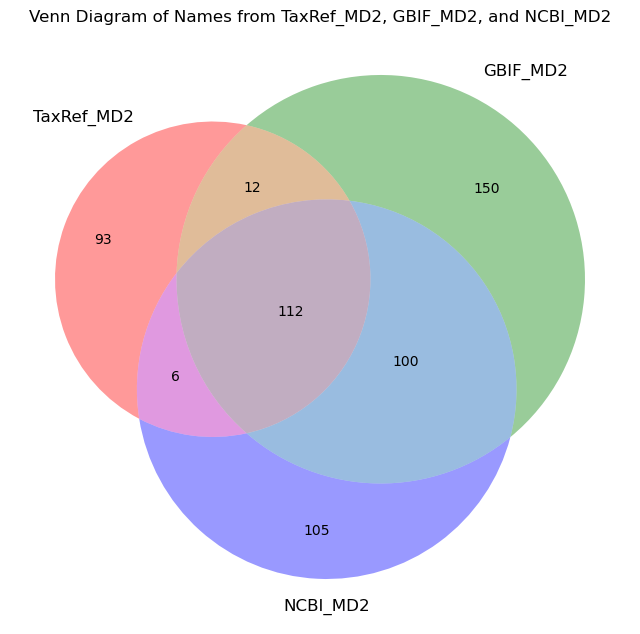

In [50]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt
import re

# Function to extract names from tuples
def extract_names(column):
    names = set()
    for row in column:
        for item in row:
            names.add(item[1])
    return names

# Extract names from each column
taxref_names = extract_names(entities_md2['TaxRef_MD2'])
gbif_names = extract_names(entities_md2['GBIF_MD2'])
ncbi_names = extract_names(entities_md2['NCBI_MD2'])

# Plot the Venn Diagram
plt.figure(figsize=(8, 8))
venn3([taxref_names, gbif_names, ncbi_names], ('TaxRef_MD2', 'GBIF_MD2', 'NCBI_MD2'))
plt.title("Venn Diagram of Names from TaxRef_MD2, GBIF_MD2, and NCBI_MD2")
plt.show()

In [56]:
max_length = max(len(unique_taxref), len(unique_gbif), len(unique_ncbi))

# Pad lists with None to make them of equal length
unique_taxref_list = list(unique_taxref)# + [None] * (max_length - len(unique_taxref))
unique_gbif_list = list(unique_gbif) #+ [None] * (max_length - len(unique_gbif))
unique_ncbi_list = list(unique_ncbi) #+ [None] * (max_length - len(unique_ncbi))

# Create a DataFrame with the unique names for each set
unique_names = {
    'TaxRef_MD2': unique_taxref_list,
    'GBIF_MD2': unique_gbif_list,
    'NCBI_MD2': unique_ncbi_list
}
# Display the DataFrame
unique_names

{'TaxRef_MD2': ['Guineafowl moray',
  'Pink Sea Fan',
  'Chafer',
  'Common Starling',
  'Pyralis palpalis',
  'Bird flies',
  'Calathus fuscipes fuscipes',
  'Mottled Owl',
  'Hill myna',
  'Ardenna bulleri',
  'Mandarin dogfish',
  'Mosquito plant',
  'English Iris',
  'Clove Pink',
  'Caperea',
  'Water Melon',
  'Rattus rattus',
  'Guiana chestnut',
  'case moths',
  'Asian kelp',
  'House Mouse',
  'Macropus rufogriseus',
  'Hygrophorus citrinus sensu Lange, sensu Bon, non sensu Rea, 1910',
  'Barn Owl',
  'Herring',
  'Pepper Pot',
  'Monk Parakeet',
  'Cotton Spinner',
  'Neurocaulon grandifolium Rodríguez',
  'Comb rockling',
  'Ingliseria',
  'Larus novaehollandiae',
  'Golden Grey Mullet',
  'Para grass',
  'Asian red seaweed',
  'Ficus',
  'Oliviereus',
  'Saltmarsh fleabane',
  'Morel',
  'Mute Swan',
  'Hieracium laggeri subsp. laggeri',
  'Proto novaehollandiae',
  'cockles',
  'Gallirallus',
  'Dragon Arum',
  'Bamboo borer',
  'Polytrichum commune var. commune',
  'Crat

In [26]:
import pandas as pd
import ast

def count_unique_entities_per_row_and_sort(column):
    # Process each row as a list of tuples
    #return column.apply(lambda x: {i: x.count(i) for i in set(x)} if isinstance(x, list) and x else {})
    return column.apply(lambda x: {k: v for k, v in sorted({i: x.count(i) for i in set(x)}.items(), key=lambda item: item[1], reverse=True)} if isinstance(x, list) and x else {})


def safely_convert_to_list(column):
    # Convert strings that represent lists or tuples safely
    return column.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and (x.startswith('[') or x.startswith('(')) else x)

# Assuming papers_df is defined and preprocessed correctly
entities_df = papers_df.copy()

columns_to_process = [
    'TaxoEntitiesMD2_x',
    'TaxoEntitiesMD_x',
    'TaxoEntitiesBB',
    'TaxoEntitiesBB2',
    'TaxoRefEntitiesBB2_x',
    'TaxoRefEntitiesBB2_y',
    'TaxoEntitiesMD2_y',
    'TaxoEntitiesMD2_GBIF',
    'TaxoEntitiesMD2',
    'TaxoEntitiesMD_y',
    'TaxoEntitiesMD2_NCBI',
    'BABEL_entities'
]

for col in columns_to_process:
    try:
        # Safely convert columns to lists or tuples if they are not already
        entities_df[col] = safely_convert_to_list(entities_df[col])
        
        # Apply the function and store the result in a new column
        new_col_name = f'{col}Counts'
        entities_df[new_col_name] = count_unique_entities_per_row_and_sort(entities_df[col])
    except Exception as e:
        print(f"Error processing column {col}: {e}")

# Display the DataFrame with the new columns
entities_df[:-9]


,BABEL_entities,TaxoEntitiesBB,TaxoEntitiesBB2,TaxoEntitiesMD2,TaxoEntitiesMD2_GBIF,TaxoEntitiesMD2_x,TaxoEntitiesMD2_y,TaxoEntitiesMD_x,TaxoEntitiesMD_y,TaxoRefEntitiesBB2_x,...,TaxoEntitiesBBCounts,TaxoEntitiesBB2Counts,TaxoRefEntitiesBB2_xCounts,TaxoRefEntitiesBB2_yCounts,TaxoEntitiesMD2_yCounts,TaxoEntitiesMD2_GBIFCounts,TaxoEntitiesMD2Counts,TaxoEntitiesMD_yCounts,TaxoEntitiesMD2_NCBICounts,BABEL_entitiesCounts
0,"[France (LOC), Creative Commons Attribution (M...","[clove agroforests, clove agroforests, clove, ...","[Stéphanie M. Carrière3, Verohanitra Rafidison...","[M. Carrière, Eric A. Penot, Verohanitra Rafid...","[(GBIF:3183002, clove), (GBIF:3183002, Syzygiu...","[M. Carrière, Eric A. Penot, Verohanitra Rafid...","[(TAXREF:630768, Syzygium aromaticum), (TAXREF...","[Verohanitra Rafidison,, Vanesse Labeyrie, Lar...","[Verohanitra Rafidison,, Vanesse Labeyrie, Lar...","[(TAXREF:447477, Coffee tree), (TAXREF:630768,...",...,"{'vanilla': 19, 'clove trees': 17, 'jackfruit'...","{'vanilla': 18, 'clove trees': 15, 'jackfruit'...","{('TAXREF:446267', 'Vanilla'): 19, ('TAXREF:42...",{},"{('TAXREF:423402', 'Gobius banana'): 7, ('TAXR...","{('GBIF:3183002', 'clove'): 11, ('GBIF:4270898...","{'banana': 6, 'clove trees': 6, 'clove': 5, 't...","{'clove trees': 9, 'banana': 6, 'tsabo': 5, 'c...","{('NCBI:219868', 'clove'): 12, ('NCBI:4641', '...","{'M (PER)': 35, 'J (PER)': 31, 'A (PER)': 30, ..."
1,"[France (LOC), Cloggs Cave (LOC), SE (LOC), Au...","[disc- faced owls, Tyto novaehollandae, Masked...","[disc- faced owls, Tyto novaehollandae, Masked...","[GunaiKurnai Land and Waters, Cloggs Cave, Tyt...","[(GBIF:9065640, Tyto novaehollandiae novaeholl...","[GunaiKurnai Land and Waters, Cloggs Cave, Tyt...","[(TAXREF:712345, Proto novaehollandiae), (TAXR...","[Larchive ouverte pluridisciplinaire HAL, Clog...","[Larchive ouverte pluridisciplinaire HAL, Clog...","[(TAXREF:712345, Proto novaehollandiae), (TAXR...",...,"{'P. higginsi': 8, 'Pseudomys higginsi': 5, 'M...","{'P. higginsi': 8, 'Pseudomys higginsi': 8, 'M...","{('TAXREF:712345', 'Proto novaehollandiae'): 6...",{},"{('TAXREF:354678', 'Pseudomystides'): 8, ('TAX...","{('GBIF:5219788', 'Pseudomys higginsi'): 13, (...","{'GunaiKurnai': 8, 'Pseudomys higginsi': 7, 'P...","{'P. higginsi': 6, 'GunaiKurnai': 6, 'Pseudomy...","{('NCBI:442611', 'Pseudomys higginsi'): 13, ('...","{'J (PER)': 76, 'Cloggs Cave (LOC)': 50, 'Davi..."
2,"[People and Nature (MISC), Biraben (PER), Rose...","[popu lation, lon ger, Muthukrishna, norfolk, ...","[Muthukrishna, norfolk]","[anti‐human’, Anderies, Malthus’ theory, dant,...",[],"[anti‐human’, Anderies, Malthus’ theory, dant,...",[],"[EXISTINGTHEORIESANDMODELS, medieval agri, And...","[EXISTINGTHEORIESANDMODELS, medieval agri, And...","[(TAXREF:592318, Coralliophila norfolk)]",...,"{'Muthukrishna': 1, 'popu lation': 1, 'Howtoci...","{'norfolk': 1, 'Muthukrishna': 1}","{('TAXREF:592318', 'Coralliophila norfolk'): 1}",{},{},{},"{'Anderies': 2, 'anti‐human’': 1, 'worlddev.20...","{'Anderies': 2, 'innova': 2, 'E6724E6725': 1, ...",{},"{'M (PER)': 23, 'J (PER)': 19, 'R (PER)': 14, ..."
3,"[France (LOC), Mélanie Congretel (PER), Floren...","[guarana, guarana, Paullinia cupana, Kunth var...","[guarana, waraná, guarana, Paullinia cupana, K...","[Sateré, Paullinia cupana (Kunth var. sorbilis...","[(GBIF:5786457, Sateré Marmoset), (GBIF:378489...","[Sateré, Paullinia cupana (Kunth var. sorbilis...","[(TAXREF:841466, Paullinia cupana var. sorbili...","[Mlanie, Larchive ouverte pluridisciplinaire H...","[Mlanie, Larchive ouverte pluridisciplinaire H...","[(TAXREF:734243, Guarea guara), (TAXREF:734243...",...,"{'guarana': 65, 'waran': 11, 'Ciociola': 2, 'a...","{'guarana': 63, 'waraná': 9, 'wará': 3, 'andir...","{('TAXREF:734243', 'Guarea guara'): 67, ('TAXR...",{},"{('TAXREF:734243', 'Guarea guara'): 28, ('TAXR...","{('GBIF:3189949', 'guarana'): 33, ('GBIF:57864...","{'guarana': 26, 'guarana’': 4, 'Sateré-Mawé gu...","{'guarana': 30, 'non-humans': 3, 'Obadias Bat

In [25]:
entities_df.to_csv('C:/Users/maria/OneDrive/Documentos/Thesis/entities-20_comparison-Counts_v2.csv', index=False, encoding='utf-8')
entities_df.to_excel('C:/Users/maria/OneDrive/Documentos/Thesis/entities-20_comparison-Counts_v2.xlsx', index=False, engine='openpyxl')

In [28]:
filtered_papers_df = entities_df[['fileMain_s','TaxoEntityMDCounts','TaxoEntityMD2Counts','TaxoEntityBBCounts','TaxoEntityBB2Counts', 'TaxoRefEntitiesBB2Counts']]
entities_df.to_csv('C:/Users/maria/OneDrive/Documentos/Thesis/entities-20_TaxoNERD-Counts_v2.csv', index=False, encoding='utf-8')
filtered_papers_df.to_excel('C:/Users/maria/OneDrive/Documentos/Thesis/entities-20_TaxoNERD-Counts_v2.xlsx', index=False, engine='openpyxl')

## Entities for all completed papers with more than half authors with gender (Dataset_2)
Now that entities have been extracted with TaxoNERD, we label them

In [11]:
papers_path = 'C:/Users/maria/OneDrive/Documentos/Thesis/Papers_Dataset/papers.csv'
papers_df = pd.read_csv(papers_path)
papers_df

,title_s,journalTitle_s,authLastName_s,authFullName_s,abstract_s,fileMain_s,ePublicationDateY_i,Complete,Genders,unknownGenders,content_text,cleaned_content_text,contentLen
0,"[""Exploring farmers' agrobiodiversity manageme...",People and Nature,"['Mariel', 'Carrière', 'Penot', 'Danthu', 'Raf...","['Juliette Mariel', 'Stéphanie M. Carrière', '...","[""1. Interactions between farmers and agrobiod...",https://hal.inrae.fr/hal-03461601/document,NaN,True,"['female', 'female', 'male', 'male', 'unknown'...",33.333333,HAL Id: hal-03461601 https://hal.inrae.fr/hal-...,httpshalinraefrhal dec multidisciplinary open ...,48604
1,['Interpreting the mammal deposits of Cloggs C...,People and Nature,"['Mcdowell', 'David', 'Mullett', 'Fresløv', 'D...","['Matthew Mcdowell', 'Bruno David', 'Russell M...","[""Palaeontological animal bone deposits are ra...",https://hal.science/hal-03829927/document,NaN,True,"['male', 'male', 'male', 'female', 'unknown', ...",8.333333,HAL Id: hal-03829927 https://hal.science/hal-0...,httpshalsciencehal mar multidisciplinary open ...,47810
2,['An ecological theory of changing human popul...,People and Nature,"['Henderson', 'Loreau']","['Kirsten Henderson', 'Michel Loreau']",['The dependence of humans on nature has come ...,https://hal.science/hal-02350603/document,NaN,True,"['female', 'male']",0.000000,People and Nature. 2019;1:31–43. | 31 wileyonl...,people nature wileyonlinelibrarycomjournalpan ...,47819
3,"['Local knowledge, know‐how and knowledge mobi...",People and Nature,"['Congretel', 'Pinton']","['Mélanie Congretel', 'Florence F. Pinton']","[""More than 30 years after the 1988 Declaratio...",https://shs.hal.science/halshs-02937670/document,NaN,True,"['female', 'female']",0.000000,HAL Id: halshs-02937670 https://shs.hal.scienc...,halshs httpsshshalsciencehalshs multidisciplin...,68504
4,['From biodiversity to health: Quantifying the...,People and Nature,"['Ulrich', 'Batáry', 'Baudry', 'Beaumelle', 'B...","['Werner Ulrich', 'Péter Batáry', 'Julia Baudr...",['Ample evidence suggests positive effects of ...,https://cnam.hal.science/hal-04080723/document,NaN,True,"['male', 'male', 'female', 'female', 'male', '...",0.000000,People and Nature. 2023;5:69–83. | 69 wileyonl...,people nature wileyonlinelibrarycomjournalpan ...,58880
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1151,['Unidirectional response to bidirectional sel...,Ecology and Evolution,"['Renneville', 'Millot', 'Agostini', 'Carmigna...","['Clémentine Renneville', 'Alexis Millot', 'Si...",['Anthropogenic perturbations such as harvesti...,https://hal.sorbonne-universite.fr/hal-0295053...,NaN,True,"['female', 'male', 'male', 'male', 'female', '...",0.000000,HAL Id: hal-02950535 https://hal.sorbonne-univ...,httpshalsorbonneuniversitefrhal sep multidisci...,55877
1152,"['Think globally, measure locally: The MIREN s...",Ecology and Evolution,"['Haider', 'Lembrechts', 'Mcdougall', 'Pauchar...","['Sylvia Haider', 'Jonas J. Lembrechts', 'Keit...",['Climate change and other global change drive...,https://u-picardie.hal.science/hal-03619105/do...,NaN,True,"['female', 'male', 'male', 'male', 'male', 'fe...",13.793103,HAL Id: hal-03619105 https://u-picardie.hal.sc...,httpsupicardiehalsciencehal oct multidisciplin...,77580
1153,['Adaptation and plasticity in aboveground all...,Ecology and Evolution,"['Vizcaíno-Palomar', 'Ibáñez', 'González-Martí...","['Natalia Vizcaíno-Palomar', 'Inés Ibáñez', 'S...","[""Plant species aboveground allometry can be v...",https://hal.inrae.fr/hal-02636091/document,NaN,True,"['female', 'female', 'male', 'male', 'male']",0.000000,HAL Id: hal-02636091 https://hal.inrae.fr/hal-...,httpshalinraefrhal multidisciplinary open acce...,36497
1154,['Foraging and mating behaviors of Hypsignathu...,Ecology and Evolution,"['Schloesing', 'Caron', 'Chambon', 'Courbin', ...","['Elodie Schloesing', 'Alexandre Caron', 'Rémi...",['Studying wildlife space use in human-modifie...,https://hal.science/hal-04167917/document,2023.0,True,"['female', 

In [13]:
#Filter by papers that we know more than half of their authors' genders
papers_df = papers_df[papers_df['unknownGenders']<50]
papers_df

,title_s,journalTitle_s,authLastName_s,authFullName_s,abstract_s,fileMain_s,ePublicationDateY_i,Complete,Genders,unknownGenders,content_text,cleaned_content_text,contentLen
0,"[""Exploring farmers' agrobiodiversity manageme...",People and Nature,"['Mariel', 'Carrière', 'Penot', 'Danthu', 'Raf...","['Juliette Mariel', 'Stéphanie M. Carrière', '...","[""1. Interactions between farmers and agrobiod...",https://hal.inrae.fr/hal-03461601/document,NaN,True,"['female', 'female', 'male', 'male', 'unknown'...",33.333333,HAL Id: hal-03461601 https://hal.inrae.fr/hal-...,httpshalinraefrhal dec multidisciplinary open ...,48604
1,['Interpreting the mammal deposits of Cloggs C...,People and Nature,"['Mcdowell', 'David', 'Mullett', 'Fresløv', 'D...","['Matthew Mcdowell', 'Bruno David', 'Russell M...","[""Palaeontological animal bone deposits are ra...",https://hal.science/hal-03829927/document,NaN,True,"['male', 'male', 'male', 'female', 'unknown', ...",8.333333,HAL Id: hal-03829927 https://hal.science/hal-0...,httpshalsciencehal mar multidisciplinary open ...,47810
2,['An ecological theory of changing human popul...,People and Nature,"['Henderson', 'Loreau']","['Kirsten Henderson', 'Michel Loreau']",['The dependence of humans on nature has come ...,https://hal.science/hal-02350603/document,NaN,True,"['female', 'male']",0.000000,People and Nature. 2019;1:31–43. | 31 wileyonl...,people nature wileyonlinelibrarycomjournalpan ...,47819
3,"['Local knowledge, know‐how and knowledge mobi...",People and Nature,"['Congretel', 'Pinton']","['Mélanie Congretel', 'Florence F. Pinton']","[""More than 30 years after the 1988 Declaratio...",https://shs.hal.science/halshs-02937670/document,NaN,True,"['female', 'female']",0.000000,HAL Id: halshs-02937670 https://shs.hal.scienc...,halshs httpsshshalsciencehalshs multidisciplin...,68504
4,['From biodiversity to health: Quantifying the...,People and Nature,"['Ulrich', 'Batáry', 'Baudry', 'Beaumelle', 'B...","['Werner Ulrich', 'Péter Batáry', 'Julia Baudr...",['Ample evidence suggests positive effects of ...,https://cnam.hal.science/hal-04080723/document,NaN,True,"['male', 'male', 'female', 'female', 'male', '...",0.000000,People and Nature. 2023;5:69–83. | 69 wileyonl...,people nature wileyonlinelibrarycomjournalpan ...,58880
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1151,['Unidirectional response to bidirectional sel...,Ecology and Evolution,"['Renneville', 'Millot', 'Agostini', 'Carmigna...","['Clémentine Renneville', 'Alexis Millot', 'Si...",['Anthropogenic perturbations such as harvesti...,https://hal.sorbonne-universite.fr/hal-0295053...,NaN,True,"['female', 'male', 'male', 'male', 'female', '...",0.000000,HAL Id: hal-02950535 https://hal.sorbonne-univ...,httpshalsorbonneuniversitefrhal sep multidisci...,55877
1152,"['Think globally, measure locally: The MIREN s...",Ecology and Evolution,"['Haider', 'Lembrechts', 'Mcdougall', 'Pauchar...","['Sylvia Haider', 'Jonas J. Lembrechts', 'Keit...",['Climate change and other global change drive...,https://u-picardie.hal.science/hal-03619105/do...,NaN,True,"['female', 'male', 'male', 'male', 'male', 'fe...",13.793103,HAL Id: hal-03619105 https://u-picardie.hal.sc...,httpsupicardiehalsciencehal oct multidisciplin...,77580
1153,['Adaptation and plasticity in aboveground all...,Ecology and Evolution,"['Vizcaíno-Palomar', 'Ibáñez', 'González-Martí...","['Natalia Vizcaíno-Palomar', 'Inés Ibáñez', 'S...","[""Plant species aboveground allometry can be v...",https://hal.inrae.fr/hal-02636091/document,NaN,True,"['female', 'female', 'male', 'male', 'male']",0.000000,HAL Id: hal-02636091 https://hal.inrae.fr/hal-...,httpshalinraefrhal multidisciplinary open acce...,36497
1154,['Foraging and mating behaviors of Hypsignathu...,Ecology and Evolution,"['Schloesing', 'Caron', 'Chambon', 'Courbin', ...","['Elodie Schloesing', 'Alexandre Caron', 'Rémi...",['Studying wildlife space use in human-modifie...,https://hal.science/hal-04167917/document,2023.0,True,"['female', 

In [9]:
from collections import Counter

#entities_df = papers_entities_df.copy()
#Create an empty list to store all entities
all_entities = []

#Iterate over the 'entities' column and append all entities to the list
for entities in entities_df['TaxoRefEntitiesBB2']:
    for entity in entities:
        all_entities.append(entity)

#Create a Counter object from the list of entities
entity_counts = Counter(all_entities)

#Create a new DataFrame with the entity counts
webpage_NamedEntities = pd.DataFrame({'entity': entity_counts.keys(), 'count': entity_counts.values()})

#Sort the DataFrame by count in descending order
webpage_NamedEntities = webpage_NamedEntities.sort_values(by='count', ascending=False)

webpage_NamedEntities = webpage_NamedEntities.reset_index(drop=True)
webpage_NamedEntities

,entity,count
0,',3404
1,,3023
2,",",2537
3,0,1835
4,1,1605
...,...,...
66,Y,3
67,U,2
68,J,2
69,Z,2


In [19]:
webpage_NamedEntities.to_csv('C:/Users/maria/OneDrive/Documentos/Thesis/entities_dataset2.csv', index=False, encoding = 'utf-8-sig')

In [14]:
webpage_NamedEntities

,entity,count,type
0,jo (PER),350,PER
1,wil (PER),243,PER
2,e (MISC),82,MISC
3,john wiley (PER),56,PER
4,euro (LOC),53,LOC
...,...,...,...
2447,suzukii (LOC),1,LOC
2448,w (MISC),1,MISC
2449,##rski (PER),1,PER
2450,wileyblackwell (MISC),1,MISC


In [13]:
#Extract the entity type from the "entity" column
webpage_NamedEntities['type'] = webpage_NamedEntities['entity'].str.split('(', 1).str[1].str[:-1]

#Count the occurrences of each entity type
entity_counts = webpage_NamedEntities['type'].value_counts()

#Xreate a new dataframe with entity type and count
entity_counts_df = pd.DataFrame({'entity type': entity_counts.index, 'count': entity_counts.values})

entity_counts_df

C:\Users\maria\AppData\Local\Temp\ipykernel_22124\2371940661.py:2: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  webpage_NamedEntities['type'] = webpage_NamedEntities['entity'].str.split('(', 1).str[1].str[:-1]


,entity type,count
0,LOC,839
1,MISC,755
2,PER,743
3,ORG,115


# TaxoNERD

https://github.com/nleguillarme/taxonerd/blob/main/README.md#use-as-python-module